# Tugas 6.2 : Uji Coba Model Logistic Regression

Pada Tugas 6.2 ini diminta untuk melakukan uji coba model yang telah dibuat dengan algoritma Logistic Regression dari data SVD (Singular Value Decomposition).

Dibuat Oleh:

*   Nama : Sabil Ahmad Hidayat
*   NIM : 220411100058
*   Kelas : PPW A

Link Code : https://colab.research.google.com/drive/1kOIWgzTUapCLbDVpFRFWMu5hCXrKnHxp?usp=sharing

Link Github : https://github.com/meinhere/ppw/tree/master/publish/tugas-6

## Import Library

In [73]:
!pip install -q Sastrawi

In [74]:
# library awal untuk perhitungan dan pengolahan teks
import numpy as np
import re
import pandas as pd

# alat untuk crawling
from urllib.request import urlopen
from bs4 import BeautifulSoup

# monitoring
from tqdm import tqdm

# library untuk praproses teks
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# library untuk proses modeling
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# library untuk evaluasi model
from sklearn.metrics import classification_report, confusion_matrix

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# save model
import pickle
import requests

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**preprocessing** disini digunakan untuk melakukan proses encoding pada label

**train_test_split** digunakan untuk membagi dataset menjadi data training dan testing

**LogisticRegression** digunakan untuk tahap modeling menggunakan library LogisticRegression

**classification_report** dan **confusion_matrix** digunakan untuk melihat laporan dan hasil evaluasi setelah proses training data

**matplotlib** dan **seaborn** digunakan untuk plotting grafik

**pickle** digunakan untuk menyimpan model hasil training dan testing

## Persiapan Data

### Load Data

In [75]:
main_df = pd.read_csv('https://raw.githubusercontent.com/meinhere/ppw/master/publish/tugas-2/dataset/data_berita.csv', delimiter=',')
main_df

,No,Judul Berita,Isi Berita,Tanggal Berita,Kategori Berita
0,1,Simak Jadwal dan Lokasi SIM Keliling di Jakart...,"JAKARTA, KOMPAS.com - Surat Izin Mengemudi (S...",07/09/2024,OTOMOTIF
1,2,[POPULER OTOMOTIF] Diskon Motor Honda Septembe...,"JAKARTA, KOMPAS.com - Banyak pembaca yang ingi...",07/09/2024,OTOMOTIF
2,3,"Cek Saldo Minimal BRI, BNI, BCA, Mandiri, dan BSI","JAKARTA, KOMPAS.com - Penting bagi calon nasab...",06/09/2024,MONEY
3,4,"KAI Uji Coba Teknologi ""Face Recognition Board...",KOMPAS.com - PT Kereta Api Indonesia (KAI) Div...,06/09/2024,MONEY
4,5,OJK Blokir 10.890 Entitas Keuangan Ilegal Seja...,"JAKARTA, KOMPAS.com - Otoritas Jasa Keuangan (...",06/09/2024,MONEY
...,...,...,...,...,...
95,96,Waspada Masalah yang Timbul akibat Telat Ganti...,"JAKARTA, KOMPAS.com - Oli mesin pada mobil den...",06/09/2024,OTOMOTIF
96,97,"Sosok Faisal Basri di Mata Para Tokoh, Ekonom ...","JAKARTA, KOMPAS.com - Ekonom senior Faisal Bas...",06/09/2024,MONEY
97,98,"Pendaftaran CPNS Diperpanjang 4 Hari, Pelamar ...","JAKARTA, KOMPAS.com - Pemerintah telah memperp...",06/09/2024,MONEY
98,99,"Harga Emas Terbaru Pegadaian, Jumat 6 Septembe...","JAKARTA, KOMPAS.com - Pegadaian menyediakan be...",06/09/2024,MONEY


### Membuat Fungsi untuk Persiapan Crawling

In [76]:
# fungsi untuk mengambil link yang akan dilakukan crawling
def extract_urls(url):
    html = urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')

    urls = soup.find_all("a", {"class": "paging__link"})
    urls = [url.get('href') for url in urls]

    return urls

# fungsi untuk mengambil isi dari berita
def get_content(url):
    html = urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')

    div = soup.find("div", {"class": "read__content"})
    paragraf = div.find_all("p")

    content = ''
    for p in paragraf:
        content += p.text

    return content


# fungsi utama crawling
def crawl(link = "https://indeks.kompas.com", max_money = 1, max_otomotif = 1, allow_category = ["OTOMOTIF", "MONEY"], is_train = True, title_old = []):
    # inisialisasi variabel penampung hasil berita
    news_data = []

    # inisialisasi persiapan untuk crawling berita
    last_url = extract_urls(link).pop()
    page = last_url.split('=').pop() # jumlah halaman secara otomatis
    # page = 1 # jumlah halaman secara manual

    # persiapan link yang akan dilakukan crawling
    urls = [link + '/?page=' + str(a) for a in range(1, int(page) + 1)]
    count_money = 0
    count_otomotif = 0

    # menelusuri semua link yang telah ditentukan
    for idx, url in enumerate(urls):
        if (len(news_data) == max_money + max_otomotif) :
          break

        html = urlopen(url).read()
        soup = BeautifulSoup(html, 'html.parser')

        # mengambil data yang diperlukan pada struktur html
        links       = soup.find_all("a", {"class": "article-link"})
        titles      = soup.find_all("h2", {"class": "articleTitle"})
        dates       = soup.find_all("div", {"class": "articlePost-date"})
        categories  = soup.find_all("div", {"class": "articlePost-subtitle"})

        news_per_page = len(links) # berita artikel yang ditampilkan

        # memasukkan data ke dalam list
        for elem in tqdm(range(news_per_page), desc=f"Crawling page {idx+1}"):
          news = {}
          category = categories[elem].text
          title = titles[elem].text

          if (category in allow_category):
            if (is_train):
              cond = (category == "MONEY" and count_money < max_money) or (category == "OTOMOTIF" and count_otomotif < max_otomotif)
            else:
              cond = (category == "MONEY" and count_money < max_money) or (category == "OTOMOTIF" and count_otomotif < max_otomotif) and title not in title_old


            if (cond):
              news['No'] = len(news_data) + 1
              news['Judul Berita']     = title
              news['Isi Berita']       = get_content(links[elem].get("href"))
              news['Tanggal Berita']   = dates[elem].text
              news['Kategori Berita']  = category
              news_data.append(news)

              if (category == "MONEY"):
                count_money += 1
              else:
                count_otomotif += 1

        print(f"=======> Money: {count_money} | Otomotif: {count_otomotif} | Total: {count_money + count_otomotif}")

    return news_data

function **extract_urls** digunakan untuk melakukan ekstraksi link url yang memiliki pagination pada halaman awal, sehingga didapat beberapa url yang bisa mengarah ke halaman selanjutnya atau sebelumnya.

function **get_content** digunakan untuk melakukan proses pembuatan isi berita sesuai link berita yang dicari.

### Pengambilan Data Baru

In [77]:
title_old = main_df["Judul Berita"].tolist()

test_news = crawl(max_money=5, max_otomotif=5, is_train=False, title_old=title_old)

Crawling page 1: 100%|██████████| 15/15 [00:00<00:00, 68.89it/s]


=======> Money: 1 | Otomotif: 0 | Total: 1


Crawling page 2: 100%|██████████| 15/15 [00:00<00:00, 30.83it/s]


=======> Money: 4 | Otomotif: 0 | Total: 4


Crawling page 3: 100%|██████████| 15/15 [00:00<00:00, 12136.30it/s]


=======> Money: 4 | Otomotif: 0 | Total: 4


Crawling page 4: 100%|██████████| 15/15 [00:00<00:00, 47.77it/s]


=======> Money: 5 | Otomotif: 0 | Total: 5


Crawling page 5: 100%|██████████| 15/15 [00:00<00:00, 36074.86it/s]


=======> Money: 5 | Otomotif: 0 | Total: 5


Crawling page 6: 100%|██████████| 15/15 [00:00<00:00, 31.37it/s]


=======> Money: 5 | Otomotif: 1 | Total: 6


Crawling page 7: 100%|██████████| 15/15 [00:00<00:00, 4068.19it/s]


=======> Money: 5 | Otomotif: 1 | Total: 6


Crawling page 8: 100%|██████████| 15/15 [00:00<00:00, 16.06it/s]


=======> Money: 5 | Otomotif: 2 | Total: 7


Crawling page 9: 100%|██████████| 15/15 [00:00<00:00, 34971.96it/s]


=======> Money: 5 | Otomotif: 2 | Total: 7


Crawling page 10: 100%|██████████| 15/15 [00:00<00:00, 23643.20it/s]


=======> Money: 5 | Otomotif: 2 | Total: 7


Crawling page 11: 100%|██████████| 15/15 [00:00<00:00, 46.79it/s]


=======> Money: 5 | Otomotif: 3 | Total: 8


Crawling page 12: 100%|██████████| 15/15 [00:00<00:00, 17327.06it/s]


=======> Money: 5 | Otomotif: 3 | Total: 8


Crawling page 13: 100%|██████████| 15/15 [00:00<00:00, 30.36it/s]


=======> Money: 5 | Otomotif: 4 | Total: 9


Crawling page 14: 100%|██████████| 15/15 [00:00<00:00, 33.93it/s]

=======> Money: 5 | Otomotif: 5 | Total: 10


In [78]:
main_df = pd.DataFrame(test_news)
main_df

,No,Judul Berita,Isi Berita,Tanggal Berita,Kategori Berita
0,1,"Harga Bitcoin Kembali Sentuh Rekor Tertinggi, ...","JAKARTA, KOMPAS.com - Harga bitcoin kembali me...",07/11/2024,MONEY
1,2,PNM Kembali Buka Unit Mekaar di Wilayah 3T,"JAKARTA, KOMPAS.com – PT Permodalan Nasional M...",07/11/2024,MONEY
2,3,Djoko Siswanto Dilantik Jadi Kepala SKK Migas ...,"JAKARTA, KOMPAS.com - Menteri Energi dan Sumbe...",07/11/2024,MONEY
3,4,Apakah Danantara Bisa Berbisnis? Ini Penjelasa...,"JAKARTA, KOMPAS.com - Menteri Badan Usaha Mili...",07/11/2024,MONEY
4,5,Moratorium Kenaikan Tarif Cukai Penting untuk ...,"JAKARTA, KOMPAS.com - Pusat Penelitian Kebijak...",07/11/2024,MONEY
5,6,MPV Listrik Maxus Mifa 7 Dijadwalkan Meluncur ...,"JAKARTA, KOMPAS.com - Maxus akan resmi berbisn...",07/11/2024,OTOMOTIF
6,7,Maxus Mifa 9 yang Meluncur di GJAW 2024 Sudah ...,"JAKARTA, KOMPAS.com - Maxus Mifa 9 akan resmi ...",07/11/2024,OTOMOTIF
7,8,"United E-Motor C2000 Resmi Meluncur, Harga mul...","JAKARTA, KOMPAS.com - United E-Motor resmi me...",07/11/2024,OTOMOTIF
8,9,Kata AHM Soal Wacana Sepeda Motor Wajib Pakai ...,"JAKARTA, KOMPAS.com – Kementerian Perhubungan ...",07/11/2024,OTOMOTIF
9,10,"Merasakan Fitur Corolla Cross Hybrid GR Sport,...","JAKARTA, KOMPAS.com - Toyota Corolla Cross Hyb...",07/11/2024,OTOMOTIF


## Praproses Teks

### Membuat Fungsi

In [79]:
# Case Folding
def clean_lower(lwr):
    lwr = lwr.lower() # lowercase text
    return lwr

# Menghapus tanda baca, angka, dan simbol
def clean_punct(text):
    clean_spcl = re.compile('[/(){}\[\]\|@,;_]')
    clean_symbol = re.compile('[^0-9a-z]')
    clean_number = re.compile('[0-9]')
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub(' ', text)
    text = clean_number.sub('', text)
    return text

# Menghaps double atau lebih whitespace
def _normalize_whitespace(text):
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

# Menghapus stopwords
def clean_stopwords(text):
    stopword = set(stopwords.words('indonesian'))
    text = ' '.join(word for word in text.split() if word not in stopword) # hapus stopword dari kolom deskripsi
    return text

# Stemming with Sastrawi
def sastrawistemmer(text):
    factory = StemmerFactory()
    st = factory.create_stemmer()
    text = ' '.join(st.stem(word) for word in tqdm(text.split()) if word in text)
    return text

function **clean_lower** digunakan untuk merubah semua kata atau huruf menjadi huruf kecil semua

function **clean_punct** digunakan untuk menghapus karakter, simbol, dan angka

function **_normalize_whitespace** digunakan untuk menghapus spasi yang double atau lebih dari 2 spasi

function **clean_stopwords** digunakan untuk menghilangkan kata yang tidak perlu (kata hubung, kata tambahan dll)

function **sastrawistemmer** digunakan untuk proses stemming (mendapatkan kata dasar dari suatu kata)

### Clean Lower

In [80]:
# Buat kolom tambahan untuk data description yang telah dilakukan proses case folding
main_df['lwr'] = main_df['Isi Berita'].apply(clean_lower)
casefolding=pd.DataFrame(main_df['lwr'])
casefolding

,lwr
0,"jakarta, kompas.com - harga bitcoin kembali me..."
1,"jakarta, kompas.com – pt permodalan nasional m..."
2,"jakarta, kompas.com - menteri energi dan sumbe..."
3,"jakarta, kompas.com - menteri badan usaha mili..."
4,"jakarta, kompas.com - pusat penelitian kebijak..."
5,"jakarta, kompas.com - maxus akan resmi berbisn..."
6,"jakarta, kompas.com - maxus mifa 9 akan resmi ..."
7,"jakarta, kompas.com - united e-motor resmi me..."
8,"jakarta, kompas.com – kementerian perhubungan ..."
9,"jakarta, kompas.com - toyota corolla cross hyb..."


### Clean Punct

In [81]:
# Buat kolom tambahan untuk data description yang telah dilakukan proses penghapusan tanda baca
main_df['clean_punct'] = main_df['lwr'].apply(clean_punct)
main_df['clean_punct']

,clean_punct
0,jakarta kompas com harga bitcoin kembali men...
1,jakarta kompas com pt permodalan nasional ma...
2,jakarta kompas com menteri energi dan sumber...
3,jakarta kompas com menteri badan usaha milik...
4,jakarta kompas com pusat penelitian kebijaka...
5,jakarta kompas com maxus akan resmi berbisni...
6,jakarta kompas com maxus mifa akan resmi di...
7,jakarta kompas com united e motor resmi men...
8,jakarta kompas com kementerian perhubungan b...
9,jakarta kompas com toyota corolla cross hybr...


### Normalize Whitespace

In [82]:
main_df['clean_double_ws'] = main_df['clean_punct'].apply(_normalize_whitespace)
main_df['clean_double_ws']

,clean_double_ws
0,jakarta kompas com harga bitcoin kembali menca...
1,jakarta kompas com pt permodalan nasional mada...
2,jakarta kompas com menteri energi dan sumber d...
3,jakarta kompas com menteri badan usaha milik n...
4,jakarta kompas com pusat penelitian kebijakan ...
5,jakarta kompas com maxus akan resmi berbisnis ...
6,jakarta kompas com maxus mifa akan resmi dijua...
7,jakarta kompas com united e motor resmi menjua...
8,jakarta kompas com kementerian perhubungan ber...
9,jakarta kompas com toyota corolla cross hybrid...


### Clean Stopwords

In [83]:
# Buat kolom tambahan untuk data description yang telah dilakukan proses penghapusan stopwords
main_df['clean_sw'] = main_df['clean_double_ws'].apply(clean_stopwords)
main_df['clean_sw']

,clean_sw
0,jakarta kompas com harga bitcoin mencapai reko...
1,jakarta kompas com pt permodalan nasional mada...
2,jakarta kompas com menteri energi sumber daya ...
3,jakarta kompas com menteri badan usaha milik n...
4,jakarta kompas com pusat penelitian kebijakan ...
5,jakarta kompas com maxus resmi berbisnis indon...
6,jakarta kompas com maxus mifa resmi dijual pam...
7,jakarta kompas com united e motor resmi menjua...
8,jakarta kompas com kementerian perhubungan ber...
9,jakarta kompas com toyota corolla cross hybrid...


### Stemming dengan Sastrawi

In [84]:
# Buat kolom tambahan untuk data description yang telah dilemmatization
main_df['desc_clean_stem'] = main_df['clean_sw'].apply(sastrawistemmer)
main_df['desc_clean_stem']

100%|██████████| 261/261 [00:11<00:00, 22.67it/s]


,desc_clean_stem
0,jakarta kompas com harga bitcoin capai rekor t...
1,jakarta kompas com pt modal nasional madani pn...
2,jakarta kompas com menteri energi sumber daya ...
3,jakarta kompas com menteri badan usaha milik n...
4,jakarta kompas com pusat teliti bijak ekonomi ...
5,jakarta kompas com maxus resmi bisnis indonesi...
6,jakarta kompas com maxus mifa resmi jual pamer...
7,jakarta kompas com united e motor resmi jual s...
8,jakarta kompas com menteri hubung wacana rem a...
9,jakarta kompas com toyota corolla cross hybrid...


## Pembuatan VSM

In [85]:
# Load the saved model from file
github_raw_url = "https://raw.githubusercontent.com/meinhere/ppw/master/publish/tugas-6/model/tfidf_vectorizer.sav"

response = requests.get(github_raw_url)
response.raise_for_status()

vectorizer = pickle.loads(response.content)
vectorizer

TfidfVectorizer()

In [86]:
corpus = main_df['desc_clean_stem']
tfidf = vectorizer.transform(corpus)

tfidf.shape

(10, 3106)

In [87]:
vocabulary = vectorizer.get_feature_names_out().tolist()

tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vocabulary)
tfidf_df['label'] = main_df['Kategori Berita'].tolist()
tfidf_df

,aaion,aali,abadi,abai,abenkh,abnormal,absurd,ac,acara,access,...,yzr,za,zad,zaman,zarco,zenix,zero,zigzag,zona,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MONEY
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MONEY
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MONEY
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MONEY
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MONEY
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OTOMOTIF
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OTOMOTIF
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OTOMOTIF
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OTOMOTIF
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04023,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OTOMOTIF


## Konversi ke SVD

In [88]:
# Load the saved model from file
github_raw_url = "https://raw.githubusercontent.com/meinhere/ppw/master/publish/tugas-6/model/svd_model.pkl"

response = requests.get(github_raw_url)
response.raise_for_status()

svd = pickle.loads(response.content)
svd

TruncatedSVD(n_components=80)

In [89]:
svd_df = tfidf_df.copy()
svd_df.drop(columns=['label'], inplace=True)

svd_df

,aaion,aali,abadi,abai,abenkh,abnormal,absurd,ac,acara,access,...,yusdistira,yzr,za,zad,zaman,zarco,zenix,zero,zigzag,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04023,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
svd.transform(svd_df)

array([[ 1.85530036e-01, -1.27696577e-01, -3.80916073e-02,
        -7.97553205e-02,  6.99959863e-02, -1.31089992e-01,
         1.29845036e-02, -1.08912924e-01, -9.75001220e-02,
        -5.01598350e-02, -1.31402510e-01,  4.00235219e-02,
        -1.06742480e-02,  1.59025029e-02,  1.63229279e-02,
         2.35818378e-03,  1.76122804e-02, -4.86398219e-02,
        -4.22725743e-02, -3.58899347e-02, -1.77636094e-02,
        -2.13620343e-02,  4.35994583e-02,  4.14258709e-02,
        -5.14539962e-02, -2.42116341e-02, -1.73485413e-02,
         3.30130855e-02, -3.86310533e-02,  1.82186195e-03,
         5.70401442e-02,  4.85326049e-02, -1.01714742e-02,
         1.43632293e-02,  5.20875640e-02,  3.04955635e-02,
         1.81480338e-03, -2.13612556e-02, -3.43864878e-02,
        -5.46103374e-02, -8.45259414e-03, -1.35638073e-02,
         2.44574768e-02,  3.69165136e-02,  1.24559322e-02,
         5.29608707e-03,  2.47701219e-02, -2.20122930e-02,
         4.32358364e-02, -1.59787781e-02, -2.15425392e-0

In [91]:
# menggunakan label_encoder untuk merubah kata menjadi angka
label_encoder = preprocessing.LabelEncoder()

svd_df = pd.DataFrame(svd.transform(svd_df), columns=[f"fitur_{i}" for i in range(n)])
svd_df['label'] = label_encoder.fit_transform(tfidf_df['label'])

svd_df

,fitur_0,fitur_1,fitur_2,fitur_3,fitur_4,fitur_5,fitur_6,fitur_7,fitur_8,fitur_9,...,fitur_71,fitur_72,fitur_73,fitur_74,fitur_75,fitur_76,fitur_77,fitur_78,fitur_79,label
0,0.185530,-0.127697,-0.038092,-0.079755,0.069996,-0.131090,0.012985,-0.108913,-0.097500,-0.050160,...,0.000740,0.023267,0.009781,-0.048445,0.017418,-0.016001,-0.008644,-0.000185,-0.007935,0
1,0.181556,-0.132466,0.011033,-0.062866,0.045804,-0.023010,-0.045333,-0.018734,0.026452,0.019286,...,-0.007485,0.022607,0.010349,0.003262,0.005408,-0.017759,-0.005255,-0.004539,0.020752,0
2,0.108025,-0.071694,0.000226,-0.036944,0.040162,-0.015771,0.006184,-0.009881,-0.000725,-0.003224,...,-0.008708,-0.007285,0.003685,-0.002656,-0.021014,0.001632,0.002715,0.014760,0.025047,0
3,0.118054,-0.102631,0.029150,-0.045567,0.019270,0.009511,-0.014705,-0.005457,0.024549,-0.026771,...,-0.004238,0.008641,-0.006335,-0.002854,0.007896,-0.014184,-0.002531,0.023301,0.003241,0
4,0.104933,-0.069962,0.002935,-0.038352,0.026541,-0.037930,0.003384,-0.018721,0.006774,0.004636,...,-0.005648,-0.017398,-0.009982,-0.012016,0.016895,-0.047842,0.012792,0.003684,-0.002408,0
5,0.241873,-0.058057,-0.037700,0.028319,-0.060636,0.007286,0.032534,0.005289,-0.003297,0.092456,...,0.010115,0.001908,-0.003957,0.022982,0.007205,0.043741,-0.020273,-0.021545,-0.011688,1
6,0.209488,-0.005463,-0.053148,0.009190,-0.031207,-0.019766,0.015985,0.015258,0.019682,0.052729,...,0.006767,-0.026174,-0.017603,0.023483,0.010571,0.014389,-0.010716,-0.008709,0.013407,1
7,0.236427,-0.008596,-0.050693,-0.007234,0.048723,0.094148,0.013897,-0.077628,0.019817,0.135887,...,0.036597,-0.025167,-0.014243,0.084270,0.010503,-0.014840,0.014028,0.003245,-0.010550,1
8,0.282602,-0.019730,0.072604,0.068908,-0.006561,0.115047,-0.040998,-0.030941,0.001201,0.075102,...,-0.012050,-0.014556,0.034255,0.017486,-0.019800,0.076928,0.029451,0.001495,-0.038172,1
9,0.286494,0.046992,-0.098282,0.092652,-0.059916,0.020225,-0.099841,0.064652,-0.030888,0.024168,...,0.030073,-0.002549,0.017066,-0.004153,-0.030468,0.015745,0.023719,-0.001270,-0.042913,1


## Testing Data

In [92]:
# Load the saved model from file
github_raw_url = "https://raw.githubusercontent.com/meinhere/ppw/master/publish/tugas-6/model/lr_model.sav"

response = requests.get(github_raw_url)
response.raise_for_status()

lr_model = pickle.loads(response.content)
lr_model

LogisticRegression()

In [93]:
y_test = svd_df['label']
x_test = svd_df.drop(['label'], axis=1)
y_pred = lr_model.predict(x_test)

print(y_pred)

[0 0 0 0 0 1 1 1 1 1]


In [94]:
# melihat nilai actual dan predicted
a = pd.DataFrame({'Actual value': y_test, 'Predicted value':y_pred})
a

,Actual value,Predicted value
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Confusion Matrix:
[[5 0]
 [0 5]]


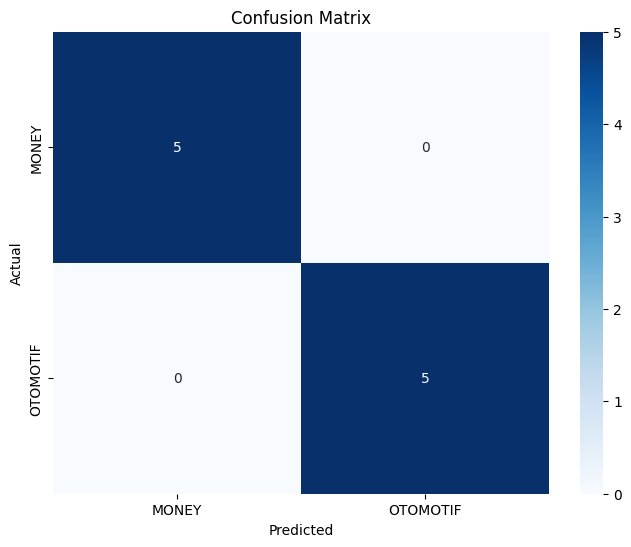

In [95]:
# Evaluation metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plotting the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()